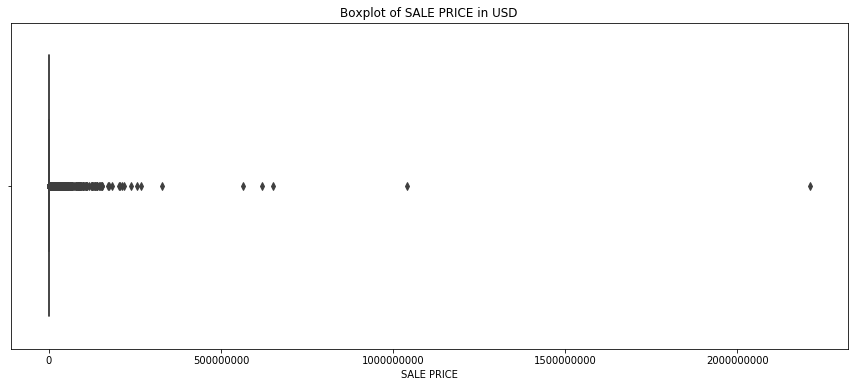

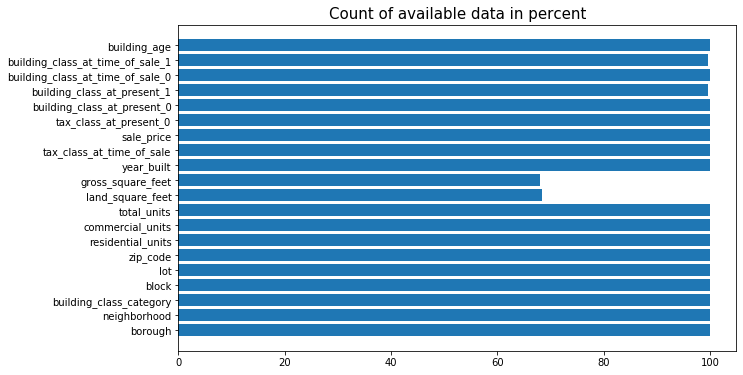

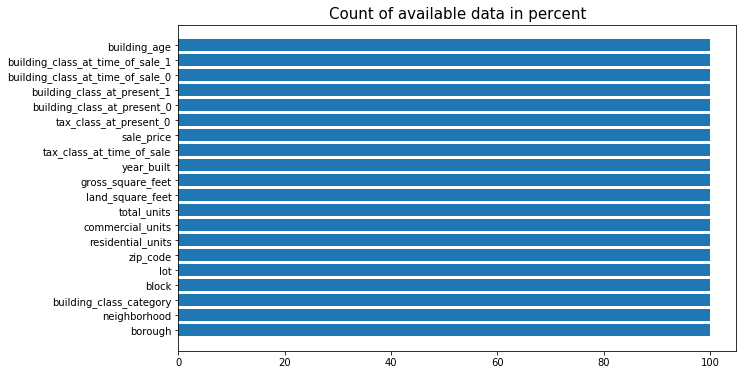

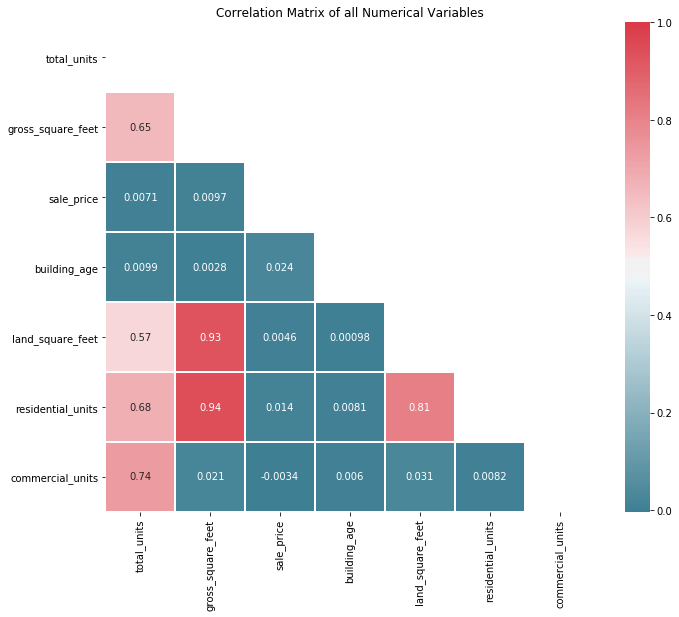

29812
borough                 : 5 unique categorical values.
building_class_category : 33 unique categorical values.
38 columns will be added during one-hot encoding.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 29812 entries, 223 to 84545
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   borough                  29812 non-null  int64
 1   building_class_category  29812 non-null  int64
dtypes: int64(2)
memory usage: 698.7 KB
      commercial_units  gross_square_feet  sale_price  building_age  \
223                  0             6330.0   -0.513493           119   
224                  0             6330.0    0.251429           119   
277                  0            12200.0   -1.235800           170   
2058                12            55473.0    1.381384            94   
2062                15            79465.0   -1.694836           107   

      land_square_feet  residential_units  borou

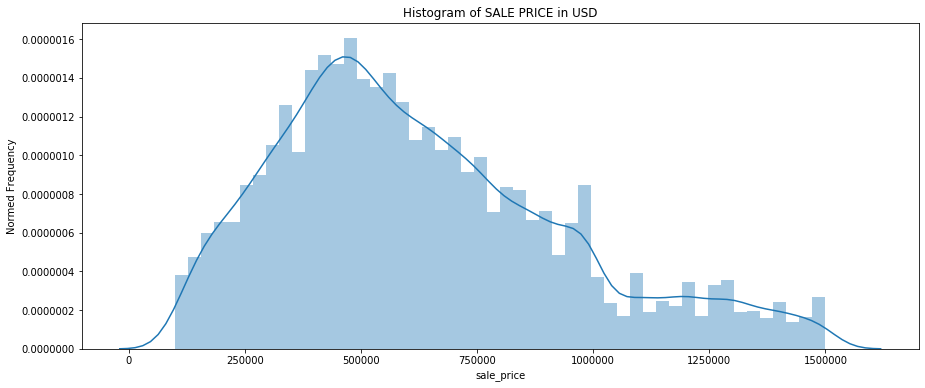

/usr/local/Cellar/python/3.7.6_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning:

invalid value encountered in log



In [20]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from datetime import date
import seaborn as sns
import random 
import warnings
import operator
# warnings.filterwarnings("ignore")
import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
from sklearn.preprocessing import StandardScaler

#------------------------------------------------------------------------
#------------------------DATA ADJASMENT----------------------------------
#------------------------------------------------------------------------

def removeBadColumns(df: pd.DataFrame) -> None:
    del df['Unnamed: 0']
    del df['SALE DATE']
    del df['APARTMENT NUMBER']
    del df['ADDRESS']
    del df['EASE-MENT']
    
    
def fixColumnNames(df: pd.DataFrame) -> None:
    df.columns = [column.lower().replace(' ', '_') for column in df.columns]

def setColumnTypes(df: pd.DataFrame) -> None:
    for column in df.columns:
        df[column] = pd.to_numeric(df[column], errors='coerce')
    # df['SALE PRICE'] = pd.to_numeric(df['SALE PRICE'], errors='coerce')
    # df['LAND SQUARE FEET'] = pd.to_numeric(df['LAND SQUARE FEET'], errors='coerce')
    # df['GROSS SQUARE FEET']= pd.to_numeric(df['GROSS SQUARE FEET'], errors='coerce')
    
    # Both TAX CLASS attributes should be categorical
    # df['BOROUGH'] = df['BOROUGH'].astype('category')
    # df['BOROUGH'] = df['BOROUGH'].astype('category')
    # df['BOROUGH'] = df['BOROUGH'].astype('category')
    # df['TAX CLASS AT TIME OF SALE'] = df['TAX CLASS AT TIME OF SALE'].astype('category')
    # df['TAX CLASS AT PRESENT'] = df['TAX CLASS AT PRESENT'].astype('category')

def splitBuildingClassColumn(df: pd.DataFrame, columnName: str, takeFirst = False) -> None:
    first = [cell[0] if len(cell) >= 1 else ''  for cell in df[columnName]]
    second = [cell[1] if len(cell) >= 2 else ''  for cell in df[columnName]]
    df[columnName + ' 0'] = first
    if not takeFirst:
        df[columnName + ' 1'] = second
    del df[columnName]

def splitBuildingClassColumns(df: pd.DataFrame) -> None:
    splitBuildingClassColumn(df, 'TAX CLASS AT PRESENT', takeFirst=True)
    splitBuildingClassColumn(df, 'BUILDING CLASS AT PRESENT')
    splitBuildingClassColumn(df, 'BUILDING CLASS AT TIME OF SALE')

def stripColumn(df: pd.DataFrame, columnName: str) -> None:
    df[columnName] = [cell.strip() for cell in df[columnName]]
    
def stripColumns(df: pd.DataFrame) -> pd.DataFrame:
    stripColumn(df, 'BUILDING CLASS CATEGORY')
    stripColumn(df, 'NEIGHBORHOOD')
    # stripColumn(df, 'TAX CLASS AT PRESENT 1')
    stripColumn(df, 'BUILDING CLASS AT PRESENT 0')
    stripColumn(df, 'BUILDING CLASS AT TIME OF SALE 0')
    
def categorizeColumn(df: pd.DataFrame, columnName: str) -> None:
    sortedCellValues = sorted(list(set(df[columnName])))
    
    m = {}
    if sortedCellValues[0] == '':
        m[''] = ''
        sortedCellValues = sortedCellValues[1:]

    for i, cellValue in enumerate(sortedCellValues):
        if cellValue == '':
            m[cellValue]: ''
        else:
            m[cellValue] = i
    df[columnName] = [m[column] for column in df[columnName]]
    df[columnName] = df[columnName].astype('category')

def categorizeColumns(df: pd.DataFrame) -> None:
    categorizeColumn(df, 'NEIGHBORHOOD')
    categorizeColumn(df, 'BUILDING CLASS CATEGORY')
    # categorizeColumn(df, 'TAX CLASS AT PRESENT 1')
    categorizeColumn(df, 'BUILDING CLASS AT PRESENT 0')
    categorizeColumn(df, 'BUILDING CLASS AT TIME OF SALE 0')
    
def removeRowsContainingNull(df: pd.DataFrame) -> pd.DataFrame:
    for column in df.columns:
        df = df[df[column].notnull()]
    return df

def removeRowsNotInRange(df: pd.DataFrame, columnName, startRange, endRange) -> pd.DataFrame:
    df = df[(df[columnName] >= startRange) & (df[columnName] <= endRange)]
    return df

def removeWrongTotalUnits(df: pd.DataFrame) -> None:
    df = df[df['total_units'] == df['commercial_units'] + df['residential_units']]
    
    
def AddingBuildingAgeColumn(df: pd.DataFrame) -> pd.DataFrame:
    temp_df = df[df['YEAR BUILT'] > 0]
    temp_df['BUILDING AGE'] = 2020 - temp_df['YEAR BUILT']
    return temp_df
    

#------------------------------------------------------------------------
#----------------------------GRAPHS--------------------------------------
#------------------------------------------------------------------------

def countNonNullData(df: pd.DataFrame) -> None:
    variables = df.columns

    count = []
    
    for variable in variables:
        length = df[variable].count()
        count.append(length)
        
    count_pct = np.round(100 * pd.Series(count) / len(df), 2)
    
    plt.figure(figsize=(10,6))
    plt.barh(variables, count_pct)
    plt.title('Count of available data in percent', fontsize=15)
    plt.show()

def boxplotOfData(df: pd.DataFrame, columnName: str) -> None:
    plt.figure(figsize=(15,6))
    
    sns.boxplot(x=columnName, data=df)
    plt.ticklabel_format(style='plain', axis='x')
    plt.title('Boxplot of SALE PRICE in USD')
    plt.show()
    
def histogramGragh(df: pd.DataFrame, columnName: str) -> None:
    #Set the size of the plot
    plt.figure(figsize=(15,6))
    
    # Plot the data and configure the settings
    sns.distplot(df[columnName])
    plt.title('Histogram of SALE PRICE in USD')
    plt.ylabel('Normed Frequency')
    plt.show()

def correlationMatrix(df: pd.DataFrame) -> None:
        # Compute the correlation matrix
    d= df[['total_units','gross_square_feet','sale_price', 'building_age', 'land_square_feet', 'residential_units', 
             'commercial_units']]
    corr = d.corr()
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, 
                square=True, linewidths=.5, annot=True, cmap=cmap)
    plt.yticks(rotation=0)
    plt.title('Correlation Matrix of all Numerical Variables')
    plt.show()
   
#------------------------------------------------------------------------
#-----------------PREPARE & NORMALISE THE DATA---------------------------
#------------------------------------------------------------------------        
def dataPreparation(df: pd.DataFrame) -> None:
    #Choose only the variables I want to use in the model
    columns = ['borough', 'building_class_category', 'commercial_units','gross_square_feet',
           'sale_price', 'building_age', 'land_square_feet', 'residential_units']
    data_model = df.loc[:,columns]
    #Select the variables to be one-hot encoded
    one_hot_features = ['borough', 'building_class_category']
    
    # For each categorical column, find the unique number of categories. This tells us how many columns we are adding to the dataset.
    longest_str = max(one_hot_features, key=len)
    total_num_unique_categorical = 0
    for feature in one_hot_features:
        num_unique = len(df[feature].unique())
        print('{col:<{fill_col}} : {num:d} unique categorical values.'.format(col=feature, 
                                                                              fill_col=len(longest_str),
                                                                              num=num_unique))
        total_num_unique_categorical += num_unique
    print('{total:d} columns will be added during one-hot encoding.'.format(total=total_num_unique_categorical))
    data_model['sale_price'] = StandardScaler().fit_transform(np.log(data_model['sale_price']).values.reshape(-1,1))

    # Convert categorical variables into dummy/indicator variables (i.e. one-hot encoding).
    one_hot_encoded = pd.get_dummies(data_model[one_hot_features])
    one_hot_encoded.info(verbose=True, memory_usage=True, null_counts=True)
    
    #Delete the old columns...
    data_model = data_model.drop(one_hot_features, axis=1)
    
    #...and add the new one-hot encoded variables
    data_model = pd.concat([data_model, one_hot_encoded], axis=1)
    print(data_model.head())
    
    #data_model['sale_price'] = [cell + 1 for cell in data_model['sale_price']]

    # Take the log and normalise
    data_model['sale_price'] = StandardScaler().fit_transform(np.log(data_model['sale_price']).values.reshape(-1,1))



#------------------------------------------------------------------------
#----------------------------"MAIN"--------------------------------------
#------------------------------------------------------------------------

df = pd.read_csv('nyc-rolling-sales.csv')
removeBadColumns(df)

splitBuildingClassColumns(df)

stripColumns(df)

categorizeColumns(df)

df = AddingBuildingAgeColumn(df)

setColumnTypes(df)

boxplotOfData(df, 'SALE PRICE')

df = removeRowsNotInRange(df, 'SALE PRICE', startRange=100000, endRange=1500000)

fixColumnNames(df)

df = df.drop_duplicates(df.columns, keep='last')

countNonNullData(df)

df = removeRowsContainingNull(df)

countNonNullData(df)

removeWrongTotalUnits(df)
correlationMatrix(df)
print(len(df))
df.head()
df.describe()
histogramGragh(df, 'sale_price')
dataPreparation(df)

#Remove data where commercial + residential doesn't equal total units

# sorted(list(set(df['building_class_category'])))

